In [12]:
# STEP 1: INPUT (Graph + Parcels)

locations = ['Warehouse', 'C1', 'C2', 'C3']

distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}

vehicle_capacity = 30
loc_to_idx = {loc: i for i, loc in enumerate(locations)}

In [13]:
# STEP 2: GREEDY PARCEL SELECTION

def greedy_select(parcels, capacity):
    items = []
    for name, info in parcels.items():
        ratio = info['value'] / info['weight']
        items.append((name, info['weight'], info['value'], ratio))

    # highest value/weight first
    items.sort(key=lambda x: x[3], reverse=True)

    selected = []
    total_weight = 0
    total_value = 0

    for name, wt, val, _ in items:
        if total_weight + wt <= capacity:
            selected.append(name)
            total_weight += wt
            total_value += val

    return selected, total_value, total_weight


sel, val, wt = greedy_select(parcels, vehicle_capacity)
print("Greedy Parcel Selection:", sel, "Value:", val, "Weight:", wt)


Greedy Parcel Selection: ['C1', 'C2'] Value: 110 Weight: 30


In [14]:
# STEP 3: CHECK TIME WINDOWS

def check_time(route):
    current_location = 'Warehouse'
    current_time = 9  # start at 9 AM

    for loc in route:
        u = loc_to_idx[current_location]
        v = loc_to_idx[loc]

        travel = distance_matrix[u][v]
        current_time += travel

        earliest, latest = parcels[loc]['time']

        if current_time < earliest:
            current_time = earliest  # wait

        if current_time > latest:
            return False  # not possible

        current_location = loc

    return True


# Example check:
print("Check Time for ['C1','C2']:", check_time(['C1','C2']))



Check Time for ['C1','C2']: False


In [15]:
# STEP 4: SIMPLE TSP BRUTE FORCE

import itertools

def tsp(locations, distance_matrix):
    n = len(locations)
    indices = list(range(1, n))  # skip warehouse
    best_cost = float('inf')
    best_route = None

    for perm in itertools.permutations(indices):
        cost = distance_matrix[0][perm[0]]
        for i in range(len(perm)-1):
            cost += distance_matrix[perm[i]][perm[i+1]]
        cost += distance_matrix[perm[-1]][0]

        if cost < best_cost:
            best_cost = cost
            best_route = perm

    final_route = ['Warehouse'] + [locations[i] for i in best_route] + ['Warehouse']
    return final_route, best_cost


route, cost = tsp(locations, distance_matrix)
print("TSP Best Route:", route)
print("TSP Best Cost:", cost)



TSP Best Route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse']
TSP Best Cost: 18


In [16]:
# STEP 5: DIJKSTRA (Shortest Path)

import heapq

def dijkstra(start):
    n = len(locations)
    dist = [float('inf')] * n
    dist[start] = 0
    pq = [(0, start)]

    while pq:
        d, u = heapq.heappop(pq)
        if d > dist[u]:
            continue

        for v in range(n):
            if u == v: continue
            newd = d + distance_matrix[u][v]
            if newd < dist[v]:
                dist[v] = newd
                heapq.heappush(pq, (newd, v))

    return dist

print("Dijkstra from Warehouse:", dijkstra(0))




Dijkstra from Warehouse: [0, 4, 8, 6]


In [17]:
# STEP 6: PRIM'S MST

def prim_mst():
    n = len(locations)
    in_mst = [False] * n
    key = [float('inf')] * n
    parent = [-1] * n

    key[0] = 0  # start from warehouse

    for _ in range(n):
        u = -1
        best = float('inf')
        for i in range(n):
            if not in_mst[i] and key[i] < best:
                best = key[i]
                u = i

        if u == -1:
            break

        in_mst[u] = True

        for v in range(n):
            if not in_mst[v] and distance_matrix[u][v] < key[v]:
                key[v] = distance_matrix[u][v]
                parent[v] = u

    edges = []
    total = 0
    for v in range(1, n):
        u = parent[v]
        edges.append((locations[u], locations[v], distance_matrix[u][v]))
        total += distance_matrix[u][v]

    return edges, total


edges, total = prim_mst()
print("MST Edges:", edges)
print("MST Total Cost:", total)

MST Edges: [('Warehouse', 'C1', 4), ('C1', 'C2', 5), ('C2', 'C3', 3)]
MST Total Cost: 12


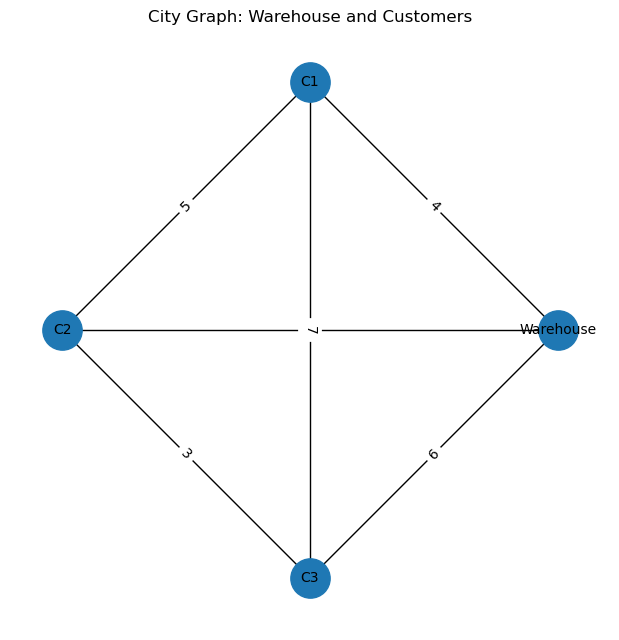

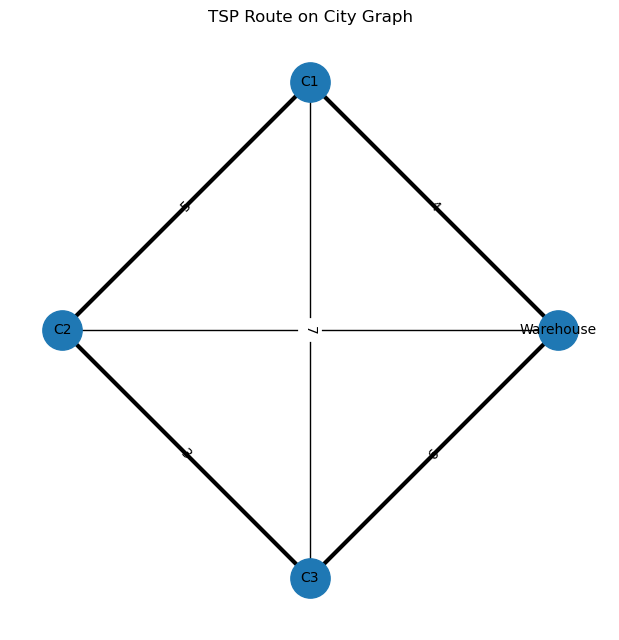

In [18]:
# STEP 7: GRAPH VISUALIZATION (CITY + ROUTE)

import networkx as nx
import matplotlib.pyplot as plt

def draw_city_graph(locations, distance_matrix):
    """
    Draws the full city graph with all locations and distances.
    """
    G = nx.Graph()

    # Add nodes
    for loc in locations:
        G.add_node(loc)

    # Add edges with weights from distance_matrix
    n = len(locations)
    for i in range(n):
        for j in range(i + 1, n):
            dist = distance_matrix[i][j]
            G.add_edge(locations[i], locations[j], weight=dist)

    # Position of nodes (simple layout)
    pos = nx.circular_layout(G)

    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_size=800, font_size=10)

    # show distance labels on edges
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.title("City Graph: Warehouse and Customers")
    plt.axis('off')
    plt.show()


def draw_route_graph(locations, distance_matrix, route):
    """
    Draws the city graph and highlights the TSP route.
    'route' should be like: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse']
    """
    G = nx.Graph()

    # Add nodes
    for loc in locations:
        G.add_node(loc)

    # Add all edges
    n = len(locations)
    for i in range(n):
        for j in range(i + 1, n):
            dist = distance_matrix[i][j]
            G.add_edge(locations[i], locations[j], weight=dist)

    pos = nx.circular_layout(G)

    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_size=800, font_size=10)

    # edge labels
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # highlight route edges
    route_edges = []
    for i in range(len(route) - 1):
        u = route[i]
        v = route[i + 1]
        route_edges.append((u, v))

    nx.draw_networkx_edges(G, pos, edgelist=route_edges, width=3)

    plt.title("TSP Route on City Graph")
    plt.axis('off')
    plt.show()


# ---- Call these after TSP step ----
draw_city_graph(locations, distance_matrix)
draw_route_graph(locations, distance_matrix, route)   # 'route' from TSP step
